In [206]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [207]:
with open("names.txt", "r") as f:
    words = f.read().splitlines()

len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [208]:
chars = sorted(set("".join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
f"{itos}"

"{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}"

In [209]:
block_size = 5
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [203]:
# mn = 0
# best = float('inf')
# for delta in range(1000):
#     g = torch.Generator().manual_seed(2147483647 + delta)
#     # Creating a map C from each of the 27 characters of our alphabet
#     # to its vector embedding of size `emb_size`. The embeddings
#     # will be learned through backpropagation later.
#     emb_size = 14
#     C = torch.randn((27, emb_size), generator=g)
#     # Block embedding = concatenation of embeddings of each of its char members
#     block_emb_size = block_size * emb_size
#     W1 = torch.randn((block_emb_size, 200), generator=g)
#     b1 = torch.randn(200, generator=g)
#     W2 = torch.randn((200, 27), generator=g)
#     b2 = torch.randn(27, generator=g)
#     parameters = [C, W1, b1, W2, b2]
#     for p in parameters:
#         p.requires_grad=True
#     # print(sum(p.nelement() for p in parameters)) # numbers of parameters in total

#     Xemb = C[Xdev]
#     h = torch.tanh(Xemb.view(-1, block_emb_size) @ W1 + b1)
#     logits = h @ W2 + b2
#     loss = F.cross_entropy(logits, Ydev).item()
#     if loss < best:
#         mn = delta
#         best = loss
# mn, best

(872, 20.649394989013672)

In [222]:
g = torch.Generator().manual_seed(2147483647 + 872)
# Creating a map C from each of the 27 characters of our alphabet
# to its vector embedding of size `emb_size`. The embeddings
# will be learned through backpropagation later.
emb_size = 14
C = torch.randn((27, emb_size), generator=g)
# Block embedding = concatenation of embeddings of each of its char members
block_emb_size = block_size * emb_size
W1 = torch.randn((block_emb_size, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad=True
print(sum(p.nelement() for p in parameters)) # numbers of parameters in total

20005


In [223]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre
# lri = []
lossi = []
stepi = []

In [224]:
for i in range(200000):
# for i in range(1000):
    
    ix = torch.randint(0, Xtr.shape[0], (128,))
    
    Xemb = C[Xtr[ix]]
    h = torch.tanh(Xemb.view(-1, block_emb_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 0.15 if i < 100000 else 0.07 if i < 180000 else 0.03  
    for p in parameters:
        p.data -= lr*p.grad

    # lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())
    # lossi.append(loss.item())

# plt.plot(lri, lossi)

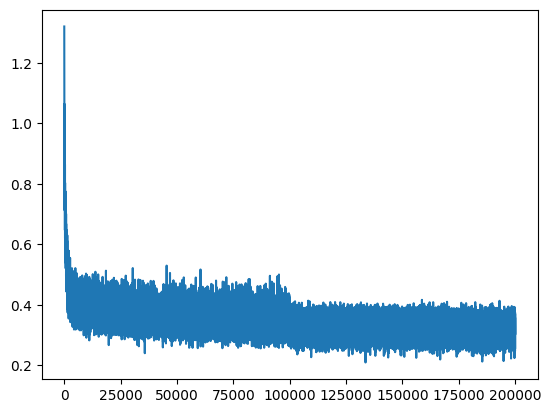

In [225]:
plt.plot(stepi, lossi)

In [226]:
Xemb = C[Xdev]
h = torch.tanh(Xemb.view(-1, block_emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
f"{loss.item():.4f}"

'2.1502'

In [227]:
Xemb = C[Xte]
h = torch.tanh(Xemb.view(-1, block_emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
f"{loss.item():.4f}"

'2.1448'

In [228]:
# ## Visualize embeddings of size 2
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
# plt.grid=("minor")

In [229]:
## Sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

jera.
hanzer.
naswaj.
bleysen.
chorlee.
chminikasy.
noyah.
jayc.
fyan.
nijennedista.
isnilaa.
anenio.
choni.
viman.
bashivann.
londyn.
redin.
marymi.
sidph.
isalethicka.
